# Covariance matrix for X

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy.random
import scipy
from scipy import integrate
from numpy import sin, cos, pi
#import pycbc.psd

In [4]:
def covX(dur, tau, dt, fs, N, fmin, fmax, tag1, tag2):

    ### Getting total noise PSD S_N
    ## Shot noise PSD
    
    freq = np.logspace(-5, 0, 1000)
    w    = 2*np.pi*freq
    
    n1_psd  = n2p_psd = ((6e-12)**2)*(1+((2e-3)/freq)**4)
    S_n_shot_x = 2.*(2*n1_psd*(1-cos(2*w*tau)) + (2*n2p_psd)*(1-cos(3*w*tau)))

    # TM-motion PSD
    delta1_psd = delta2p_psd = (2.4e-15)**2
     
    S_n_delta_x  = 2*(2*delta1_psd*(1-cos(4*w*tau)) + 4*delta2p_psd*(1-cos(2*w*tau)))
    S_n_delta_x *= (1 + ((0.4e-3)/freq)**2)*(1 + (freq/(8e-3))**4)/(w**4) # Shaping the noise


    ## DWS noise PSD
    # Yaw
    c1 = c1p = c1_FS = c1p_FS = c2 = c2p = c2_FS = c2p_FS = c3 = c3p = c3_FS = c3p_FS = 5e-3 # Upper bound on coeffs
    n_phi1_psd = n_phi1p_psd = n_phi2p_psd = n_phi3_psd = ((70e-9)/300.)**2
    
    S_n_phi_x  = n_phi1_psd*(c1**2 + c2p_FS**2 + 2*c1*c2p_FS*cos(2*w*tau))
    S_n_phi_x += n_phi1p_psd*(c1p**2 + c3_FS**2 + 2*c1p*c3_FS*cos(2*w*tau))
    S_n_phi_x += n_phi2p_psd*(c2p**2 + c1_FS**2 + 2*c2p*c1_FS)
    S_n_phi_x += n_phi3_psd*(c3**2 + c1p_FS**2 + 2*c3*c1p_FS)
    S_n_phi_x *= (2-2*cos(2*w*tau)) # TDI-X transfer fn
    #S_n_phi_x *= 0
    
    # Pitch
    c1_eta = c1p_eta = c1_FS_eta = c1p_FS_eta = c2_eta = c2p_eta = c2_FS_eta = c2p_FS_eta = c3_eta = c3p_eta = c3_FS_eta = c3p_FS_eta = 5e-3 # Upper bound on coeffs
    n_eta1_psd = n_eta1p_psd = n_eta2p_psd = n_eta3_psd = ((70e-9)/300.)**2
    
    S_n_eta_x  = n_eta1_psd*(c1_eta**2 + c2p_FS_eta**2 + 2*c1_eta*c2p_FS_eta*cos(2*w*tau))
    S_n_eta_x += n_eta1p_psd*(c1p_eta**2 + c3_FS_eta**2 + 2*c1p_eta*c3_FS_eta*cos(2*w*tau))
    S_n_eta_x += n_phi2p_psd*(c2p_eta**2 + c1_FS_eta**2 + 2*c2p_eta*c1_FS_eta)
    S_n_eta_x += n_phi3_psd*(c3_eta**2 + c1p_FS_eta**2 + 2*c3_eta*c1p_FS_eta)
    S_n_eta_x *= (2-2*cos(2*w*tau)) # TDI-X transfer fn
    #S_n_eta_x *= 0
    
    ## GW noise PSD
    m1, m2, f1, f2 = -0.34020763866501563, -7.956580873845239, 2.000050001250031e-05, 0.019400485012125303
    ampsq = (0.3e-23)**2

    S_gw_estimate  = ampsq
    S_gw_estimate *= (freq**2 + f1**2)**(m1)
    S_gw_estimate *= (freq**2 + f2**2)**(m2-m1)

    # Total noise S_N = shot noise + TM-motion noise + DWS noise + GW noise
    S_N = S_n_shot_x + S_n_delta_x +S_gw_estimate + S_n_phi_x + S_n_eta_x
    S_N_vec = [S_n_shot_x, S_n_delta_x, S_gw_estimate, S_n_phi_x, S_n_eta_x]
    
    ## Integrands
    H_modsq = 2 - 2*cos(2*w*tau)
    
    ## DWS signals
    if tag2 == 'LPF':
        
        # S/C jitters
        
        w0_y = 2*np.pi*(3.75e-3)
        w1_y = 2*np.pi*(4.5e-3)
        w2_y = 2*np.pi*(1e-1)   
        phi1_psd = phi2_psd = phi3_psd = ((4e-9)*(w**2 + w0_y**2)/((w**2 + w1_y**2)*(w**2 + w2_y**2)))**2
        
        w0 = 2*np.pi*(3e-3)
        w1 = 2*np.pi*(4e-3)
        w2 = 2*np.pi*(1e-1) 
        eta1_psd = eta2_psd = eta3_psd = ((6e-9)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
        theta1_psd = theta2_psd = theta3_psd = ((4e-8)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
        
        '''
        # Jitter
        A       = 10e-9
        T_jitt  = 24*3600
        w0_jitt = 2*pi*15e-3
        '''            
    else:
        
        # S/C jitters
        
        phi1_psd = phi2_psd = phi3_psd = ((5.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
        eta1_psd = eta2_psd = eta3_psd = ((5.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
        theta1_psd = theta2_psd = theta3_psd = ((5.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)

    # MOSA jitter
    
    MOSA_psd = ((2.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
    
    ## YAW
    # Using |H|^2 |phi|^2 ~ |H|^2 phi_psd*T
    d11 = integrate_fn(H_modsq*(phi1_psd + MOSA_psd)*dur, S_N, w, fmin, fmax)
    d12 = integrate_fn(H_modsq*(phi1_psd + MOSA_psd)*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    # d22 = d11
    d33 = integrate_fn(H_modsq*(phi1_psd + MOSA_psd)*dur, S_N, w, fmin, fmax) # != d
    d34 = integrate_fn(H_modsq*(phi1_psd + MOSA_psd)*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    # d44 = d33
    d55 = integrate_fn(H_modsq*(phi2_psd + MOSA_psd)*dur, S_N, w, fmin, fmax)
    d66 = integrate_fn(H_modsq*(phi3_psd + MOSA_psd)*dur, S_N, w, fmin, fmax)
    
    # New cross terms when considering S/C jitter, in addition to MOSA jitter
    d13 = integrate_fn(H_modsq*(-phi1_psd)*dur, S_N, w, fmin, fmax)
    d14 = integrate_fn(H_modsq*(-phi1_psd)*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    # d23 = d14
    # d24 = d13
    
    ## PITCH 
    theta_o = 30.*pi/180 # Half of opening angle b/w MOSAs
    d77 = integrate_fn(H_modsq*(eta1_psd*cos(theta_o)**2 + theta1_psd*sin(theta_o)**2 + MOSA_psd)*dur, S_N, w, fmin, fmax)
    d78 = integrate_fn(H_modsq*(eta1_psd*cos(theta_o)**2 + theta1_psd*sin(theta_o)**2 + MOSA_psd)*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    # d88 = d77
    d99 = integrate_fn(H_modsq*(eta1_psd*cos(theta_o)**2 + theta1_psd*sin(theta_o)**2 + MOSA_psd)*dur, S_N, w, fmin, fmax)
    d9X = integrate_fn(H_modsq*(eta1_psd*cos(theta_o)**2 + theta1_psd*sin(theta_o)**2 + MOSA_psd)*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    # dXX = d99
    dX1X1 = integrate_fn(H_modsq*(eta2_psd*cos(theta_o)**2 + theta2_psd*sin(theta_o)**2 + MOSA_psd)*dur, S_N, w, fmin, fmax)
    dX2X2 = integrate_fn(H_modsq*(eta3_psd*cos(theta_o)**2 + theta3_psd*sin(theta_o)**2 + MOSA_psd)*dur, S_N, w, fmin, fmax)

    # New cross terms when considering S/C jitter, in addition to MOSA jitter
    d79 = integrate_fn(-H_modsq*(eta1_psd*cos(theta_o)**2 - theta1_psd*sin(theta_o)**2)*dur, S_N, w, fmin, fmax)
    d7X = integrate_fn(-H_modsq*(eta1_psd*cos(theta_o)**2 - theta1_psd*sin(theta_o)**2)*dur*cos(2*w*tau), S_N, w, fmin, fmax)
    # d89 = d7X
    # d8X = d79
    
    d_vec = d11, d12, d33, d34, d55, d66, d77, d78, d99, d9X, dX1X1, dX2X2, d13, d14, d79, d7X

    cov_x = np.asarray(make_covX_matrix(d_vec, dur))

    if tag1 == 'plot':  
        return cov_x, H_modsq, (phi1_psd + MOSA_psd), S_N_vec, freq
    else: 
        return cov_x
    
def make_covX_matrix(d_vec, dur):
    
    d11, d12, d33, d34, d55, d66, d77, d78, d99, d9X, dX1X1, dX2X2, d13, d14, d79, d7X = d_vec
    
    # The following was taken from Mathematica (yup, its horrific)
    
    matrix = [[(-(d13**2*d33) - d14**2*d33 + 2*d13*d14*d34 + d11*(d33**2 - d34**2))/
          (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
              2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
         (2*d13*d14*d33 - d13**2*d34 - d14**2*d34 + d12*(-d33**2 + d34**2))/
          (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
              2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
         (d13**3 + d14*(d12*d33 + d11*d34) - d13*(d14**2 + d11*d33 + d12*d34))/
          (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
              2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
         (-(d13**2*d14) + d14**3 + d12*d13*d33 - d11*d14*d33 + d11*d13*d34 - d12*d14*d34)/
          (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),0,0,0,0,0,0,0,0],
              
              [(2*d13*d14*d33 - d13**2*d34 - d14**2*d34 + d12*(-d33**2 + d34**2))/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (-(d13**2*d33) - d14**2*d33 + 2*d13*d14*d34 + d11*(d33**2 - d34**2))/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (-(d13**2*d14) + d14**3 + d12*d13*d33 - d11*d14*d33 + d11*d13*d34 - d12*d14*d34)/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
            2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (d13**3 + d14*(d12*d33 + d11*d34) - d13*(d14**2 + d11*d33 + d12*d34))/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),0,0,0,0,0,0,0,0],
              
              [(d13**3 + d14*(d12*d33 + d11*d34) - d13*(d14**2 + d11*d33 + d12*d34))/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (-(d13**2*d14) + d14**3 + d12*d13*d33 - d11*d14*d33 + d11*d13*d34 - d12*d14*d34)/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (-(d11*(d13**2 + d14**2)) + d11**2*d33 + d12*(2*d13*d14 - d12*d33))/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (-(d12*(d13**2 + d14**2)) + d12**2*d34 + d11*(2*d13*d14 - d11*d34))/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),0,0,0,0,0,0,0,0],
              
              [(-(d13**2*d14) + d14**3 + d12*d13*d33 - d11*d14*d33 + d11*d13*d34 - d12*d14*d34)/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (d13**3 + d14*(d12*d33 + d11*d34) - d13*(d14**2 + d11*d33 + d12*d34))/
        (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (-(d12*(d13**2 + d14**2)) + d12**2*d34 + d11*(2*d13*d14 - d11*d34))/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),
        (-(d11*(d13**2 + d14**2)) + d11**2*d33 + d12*(2*d13*d14 - d12*d33))/
         (2.*(d13**4 + d14**4 + 4*d13*d14*(d12*d33 + d11*d34) - 2*d14**2*(d11*d33 + d12*d34) - 
             2*d13**2*(d14**2 + d11*d33 + d12*d34) + (d11**2 - d12**2)*(d33**2 - d34**2))),0,0,0,0,0,0,0,0],
              
              [0,0,0,0,1/(2.*d55),0,0,0,0,0,0,0],
              
              [0,0,0,0,0,1/(2.*d66),0,0,0,0,0,0],
              
              [0,0,0,0,0,0,(-(d79**2*d99) - d7X**2*d99 + 2*d79*d7X*d9X + d77*(d99**2 - d9X**2))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (2*d79*d7X*d99 - d79**2*d9X - d7X**2*d9X + d78*(-d99**2 + d9X**2))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (d79**3 + d7X*(d78*d99 + d77*d9X) - d79*(d7X**2 + d77*d99 + d78*d9X))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (-(d79**2*d7X) + d7X**3 + d78*d79*d99 - d77*d7X*d99 + d77*d79*d9X - d78*d7X*d9X)/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),0,0],
              
              [0,0,0,0,0,0,(2*d79*d7X*d99 - d79**2*d9X - d7X**2*d9X + d78*(-d99**2 + d9X**2))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (-(d79**2*d99) - d7X**2*d99 + 2*d79*d7X*d9X + d77*(d99**2 - d9X**2))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (-(d79**2*d7X) + d7X**3 + d78*d79*d99 - d77*d7X*d99 + d77*d79*d9X - d78*d7X*d9X)/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
            2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (d79**3 + d7X*(d78*d99 + d77*d9X) - d79*(d7X**2 + d77*d99 + d78*d9X))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),0,0],
              
              [0,0,0,0,0,0,(d79**3 + d7X*(d78*d99 + d77*d9X) - d79*(d7X**2 + d77*d99 + d78*d9X))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (-(d79**2*d7X) + d7X**3 + d78*d79*d99 - d77*d7X*d99 + d77*d79*d9X - d78*d7X*d9X)/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
            2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (-(d77*(d79**2 + d7X**2)) + d77**2*d99 + d78*(2*d79*d7X - d78*d99))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (-(d78*(d79**2 + d7X**2)) + d78**2*d9X + d77*(2*d79*d7X - d77*d9X))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),0,0],
              
              [0,0,0,0,0,0,(-(d79**2*d7X) + d7X**3 + d78*d79*d99 - d77*d7X*d99 + d77*d79*d9X - d78*d7X*d9X)/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (d79**3 + d7X*(d78*d99 + d77*d9X) - d79*(d7X**2 + d77*d99 + d78*d9X))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (-(d78*(d79**2 + d7X**2)) + d78**2*d9X + d77*(2*d79*d7X - d77*d9X))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),
        (-(d77*(d79**2 + d7X**2)) + d77**2*d99 + d78*(2*d79*d7X - d78*d99))/
         (2.*(d79**4 + d7X**4 + 4*d79*d7X*(d78*d99 + d77*d9X) - 2*d7X**2*(d77*d99 + d78*d9X) - 
             2*d79**2*(d7X**2 + d77*d99 + d78*d9X) + (d77**2 - d78**2)*(d99**2 - d9X**2))),0,0],
              
              [0,0,0,0,0,0,0,0,0,0,1/(2.*dX1X1),0],
              
              [0,0,0,0,0,0,0,0,0,0,0,1/(2.*dX2X2)]]
    
    return matrix


def integrate_fn(numerator, S_N, w, wmin, wmax):

    integrand = numerator/S_N
    
    # Set limits and resize arrays before integral
    w_max_idx = find_nearest(w, wmax)
    w = w[:w_max_idx+1] # +1 to include the index with value closest to wmax
    
    w_min_idx = find_nearest(w, wmin)
    w = w[w_min_idx:]
    
    integrand = integrand[w_min_idx:w_max_idx+1]
    result    = integrate.simps(integrand, x=w, axis=-1, even='avg')

    return result

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def return_diag_covx(covx):
    
    return covx[0][0]**0.5, covx[1][1]**0.5, covx[2][2]**0.5, covx[3][3]**0.5, covx[4][4]**0.5, covx[5][5]**0.5
    
    
    

In [5]:
fs  = 8.
dt  = 1./fs
tau = 2.5e9/3e8
dur = 1*24*3600 # 1 day
#dur = 10*60 # 10 mins
t   = np.arange(0, dur, dt)
N   = len(t)
wmin = 2*np.pi*1./dur
#wmax = 2*np.pi*4e-2
wmax = 2*np.pi

DWS = 'req'

print('T = ', dur)
print('Integration limits: ', wmin, wmax)

T =  86400
Integration limits:  7.27220521664304e-05 6.283185307179586


In [6]:
covX_matrix, H_modsq, phi1_arg, S_N_vec, freq =  covX(dur, tau, dt, fs, N, wmin, wmax, 'plot', DWS)

print('\n')
print('\n'.join([' '.join(['{:4}'.format(item) for item in row]) 
      for row in covX_matrix]))



2.637724405270552e-11 8.220849851339354e-12 2.2739003493711657e-11 7.086939527016681e-12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8.220849851339354e-12 2.637724405270552e-11 7.086939527016681e-12 2.2739003493711657e-11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2.2739003493711657e-11 7.086939527016681e-12 2.6377244052705534e-11 8.220849851339354e-12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7.086939527016681e-12 2.2739003493711657e-11 8.220849851339354e-12 2.6377244052705534e-11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0 6.116600475315142e-12  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0 6.116600475315142e-12  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 8.32053262560695e-12 2.5932144109372613e-12 3.586436476554722e-12 1.1177648323005445e-12  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 2.5932144109372613e-12 8.32053262560695e-12 1.1177648323005445e-12 3.586436476554722e-12  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 3.586436476554722e-12 1.11776483230054

In [7]:
# Trace of CovX for current integration bounds seen above

for i in range(12):
    print(0.5*covX_matrix[i][i]**0.5)
    
#print(covX_matrix[0][0]/covX_matrix[5][5])

2.5679390594748114e-06
2.5679390594748114e-06
2.5679390594748123e-06
2.5679390594748123e-06
1.2365880958624765e-06
1.2365880958624765e-06
1.4422666731231563e-06
1.4422666731231563e-06
1.4422666731231563e-06
1.4422666731231563e-06
1.2365880958624765e-06
1.2365880958624765e-06


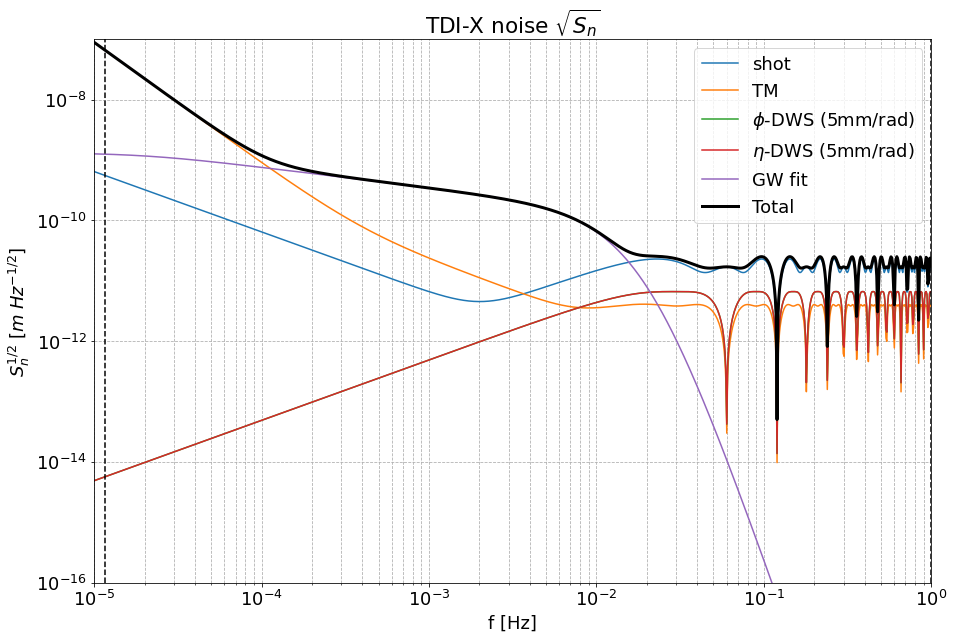

In [8]:
# Plotting various noise curves

freq = np.logspace(-5, 0, 1000)
w    = 2*np.pi*freq

S_n_shot_x, S_n_delta_x, S_gw_estimate, S_n_phi_x, S_n_eta_x = S_N_vec 
S_n = S_n_shot_x + S_n_delta_x + S_gw_estimate + S_n_phi_x + S_n_eta_x

fig = plt.figure(figsize=(15, 10))
plt.title('TDI-X noise $\\sqrt{S_n}$')
plt.loglog(freq, S_n_shot_x**0.5, label='shot')
plt.loglog(freq, S_n_delta_x**0.5, label='TM')
plt.loglog(freq, S_n_phi_x**0.5, label='$\phi$-DWS (5mm/rad)')
plt.loglog(freq, S_n_eta_x**0.5, label='$\eta$-DWS (5mm/rad)')
plt.loglog(freq, S_gw_estimate**0.5, label='GW fit')
plt.loglog(freq, S_n**0.5, label='Total', c='k', linewidth=3.0)
plt.ylabel('$S_n^{1/2}$ $[m \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
plt.ylim([1e-16, 1e-7])
#plt.axvline(x=3e-3, ls='--', c='k')
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('Figures/FIM_noise_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

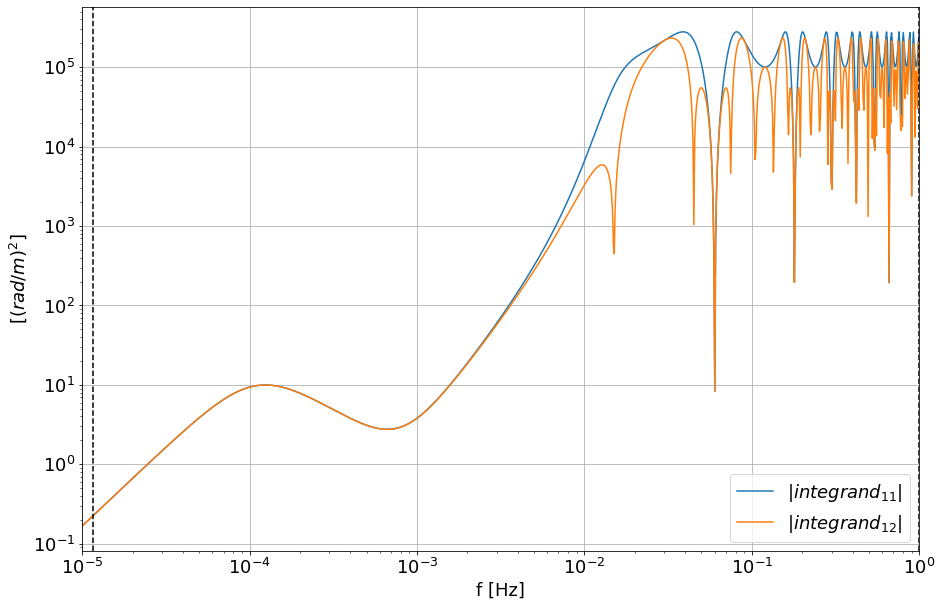

In [8]:
# Checking frequency dependence of integrands

fig = plt.figure(figsize=(15, 10))
plt.loglog(freq, np.abs(H_modsq*phi1_arg)/S_n, label='$|integrand_{11}|$')
plt.loglog(freq, np.abs(H_modsq*phi1_arg*cos(2*2*np.pi*freq*tau)/S_n), label='$|integrand_{12}|$')
#plt.semilogx(freq, H_modsq*phi1_modsq*cos(2*2*np.pi*freq*tau)/S_N, label='integrand_12')
plt.xlabel('f [Hz]')
plt.ylabel('[$(rad/m)^2$]')
plt.xlim([1e-5, 1])
#plt.ylim([1e1, 1e12])

# Integration bounds
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid()#True, which="both", ls="--")
plt.savefig('Figures/FIM_integrands_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

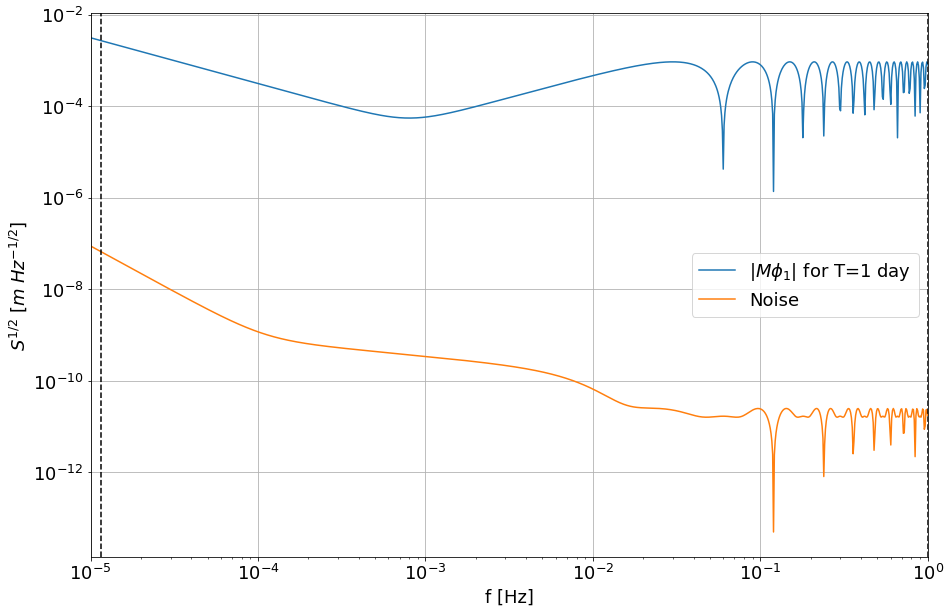

In [12]:
# Plotting integrand components individually

fig = plt.figure(figsize=(15, 10))
plt.loglog(freq, ((np.abs(phi1_arg**0.5)*dur)*H_modsq**0.5), label='$|M \phi_1|$ for T=1 day')
#plt.loglog(freq, ((np.abs(phi1_jitter_modsq)**0.5)*H_modsq**0.5), label='$|M \phi_3|$ for T=1 day')
plt.loglog(freq, S_n**0.5, label='Noise')
plt.xlabel('f [Hz]')
plt.ylabel('$S^{1/2}$ $[m \; Hz^{-1/2}]$')
plt.xlim([1e-5, 1])
plt.legend()
plt.grid()

# Integration bounds
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.savefig('Figures/FIM_integrand_components_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

<ipython-input-3-20bcfe6712c1>:140: RuntimeWarning: invalid value encountered in double_scalars
  matrix = [[(-(d13**2*d33) - d14**2*d33 + 2*d13*d14*d34 + d11*(d33**2 - d34**2))/
<ipython-input-3-20bcfe6712c1>:143: RuntimeWarning: invalid value encountered in double_scalars
  (2*d13*d14*d33 - d13**2*d34 - d14**2*d34 + d12*(-d33**2 + d34**2))/
<ipython-input-3-20bcfe6712c1>:146: RuntimeWarning: invalid value encountered in double_scalars
  (d13**3 + d14*(d12*d33 + d11*d34) - d13*(d14**2 + d11*d33 + d12*d34))/
<ipython-input-3-20bcfe6712c1>:149: RuntimeWarning: invalid value encountered in double_scalars
  (-(d13**2*d14) + d14**3 + d12*d13*d33 - d11*d14*d33 + d11*d13*d34 - d12*d14*d34)/
<ipython-input-3-20bcfe6712c1>:153: RuntimeWarning: invalid value encountered in double_scalars
  [(2*d13*d14*d33 - d13**2*d34 - d14**2*d34 + d12*(-d33**2 + d34**2))/
<ipython-input-3-20bcfe6712c1>:156: RuntimeWarning: invalid value encountered in double_scalars
  (-(d13**2*d33) - d14**2*d33 + 2*d13*d14*d

f_min =  1.1574074074074073e-05


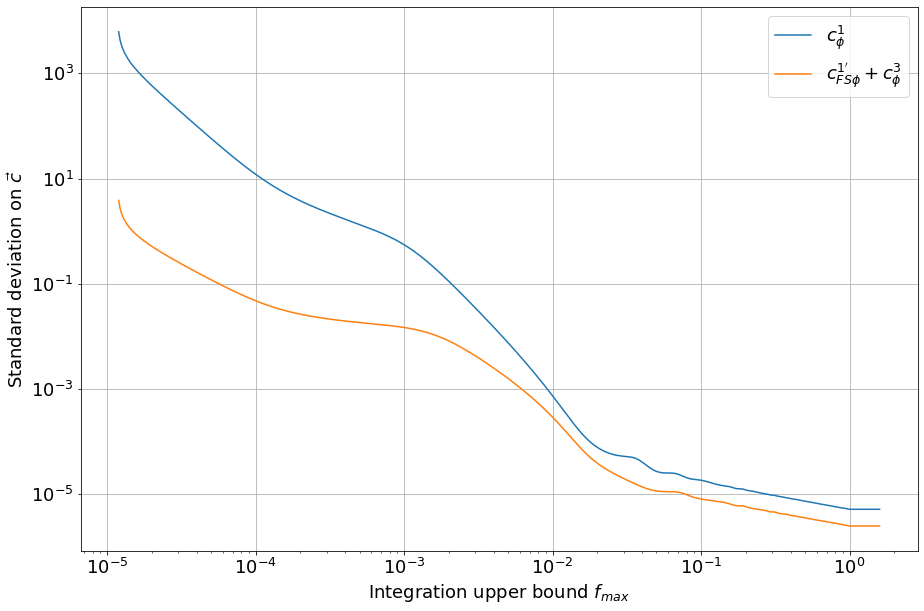

In [13]:
## Changing max bound to see if we can minimize the standard deviation on TTL coefficient c1 (keeping min bound constant)

lower_bound = int(np.log(wmin))
wmax_vec = np.logspace(lower_bound, 1, 1000)
sigma_c1_vec_max = []
sigma_c6_vec_max = []

for i in range(len(wmax_vec)):
    covX_matrix = covX(dur, tau, dt, fs, N, wmin, wmax_vec[i], 'no plot', DWS)
    sigma_c1_vec_max.append(covX_matrix[0][0]**0.5)
    sigma_c6_vec_max.append(covX_matrix[5][5]**0.5)
    
fig = plt.figure(figsize=(15, 10))
plt.loglog(wmax_vec/(2*np.pi), sigma_c1_vec_max, label='$c_{\\phi}^1$')
plt.loglog(wmax_vec/(2*np.pi), sigma_c6_vec_max, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
plt.ylabel('Standard deviation on $\\vec{c}$')
plt.xlabel('Integration upper bound $f_{max}$')
#plt.axvline(x=wmin/(2*np.pi), ls='--', c='k', label='Current $f_{min}$')
plt.legend()
plt.grid()#True, which="both", ls="--")
plt.savefig('Figures/sigma_vary-fmax_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

print('f_min = ', wmin/(2*np.pi))

<ipython-input-20-6e86720c7c8d>:139: RuntimeWarning: invalid value encountered in double_scalars
  matrix = [[(-(d13**2*d33) - d14**2*d33 + 2*d13*d14*d34 + d11*(d33**2 - d34**2))/
<ipython-input-20-6e86720c7c8d>:142: RuntimeWarning: invalid value encountered in double_scalars
  (2*d13*d14*d33 - d13**2*d34 - d14**2*d34 + d12*(-d33**2 + d34**2))/
<ipython-input-20-6e86720c7c8d>:145: RuntimeWarning: invalid value encountered in double_scalars
  (d13**3 + d14*(d12*d33 + d11*d34) - d13*(d14**2 + d11*d33 + d12*d34))/
<ipython-input-20-6e86720c7c8d>:148: RuntimeWarning: invalid value encountered in double_scalars
  (-(d13**2*d14) + d14**3 + d12*d13*d33 - d11*d14*d33 + d11*d13*d34 - d12*d14*d34)/
<ipython-input-20-6e86720c7c8d>:152: RuntimeWarning: invalid value encountered in double_scalars
  [(2*d13*d14*d33 - d13**2*d34 - d14**2*d34 + d12*(-d33**2 + d34**2))/
<ipython-input-20-6e86720c7c8d>:155: RuntimeWarning: invalid value encountered in double_scalars
  (-(d13**2*d33) - d14**2*d33 + 2*d13

f_max =  1.0 0.0008341002891283904


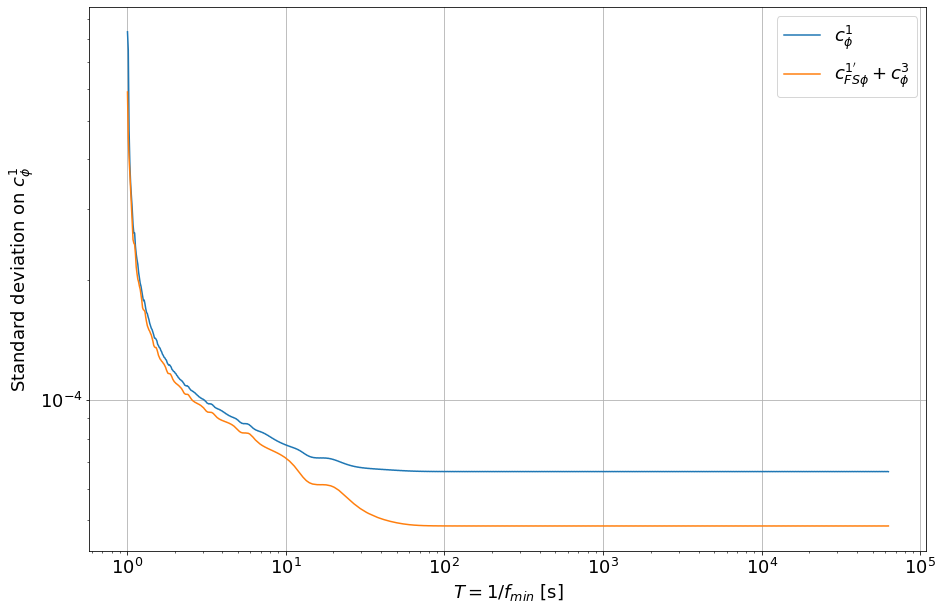

In [26]:
## Changing max bound to see if we can minimize the standard deviation on TTL coefficient c1 (keeping min bound constant)

upper_bound = int(np.log(wmax))
wmin_vec = np.logspace(-4, upper_bound, 1000)
sigma_c1_vec_min = []
sigma_c6_vec_min = []

for i in range(len(wmin_vec)):
    covX_matrix = covX(dur, tau, dt, fs, N, wmin_vec[i], wmax, 'no plot', DWS)
    sigma_c1_vec_min.append(covX_matrix[0][0]**0.5) 
    sigma_c6_vec_min.append(covX_matrix[5][5]**0.5)
    
    
T_plot = 1/(wmin_vec/(2*np.pi))

fig = plt.figure(figsize=(15, 10))
plt.loglog(T_plot, sigma_c1_vec_min, label='$c_{\\phi}^1$')
plt.loglog(T_plot, sigma_c6_vec_min, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
plt.xlabel('$T=1/f_{min}$ [s]')
#plt.loglog(wmin_vec/(2*np.pi), sigma_c1_vec_min, label='$c_{\\phi}^1$')
#plt.loglog(wmin_vec/(2*np.pi), sigma_c6_vec_min, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
#plt.xlabel('Integration lower bound $f_{min}$')

plt.ylabel('Standard deviation on $c_{\\phi}^1$')
#plt.axvline(x=wmax/(2*np.pi), ls='--', c='k', label='Current $f_{max}$')
#plt.ylim([0.99*min(sigma_c1_vec_min), 1.01*max(sigma_c1_vec_min)])
plt.tick_params(axis='y', which='major')
plt.legend()
plt.grid()#True, which="both", ls="--")

plt.savefig('Figures/sigma_vary-T_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)
#plt.savefig('Figures/sigma_vary-fmin_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

print('f_max = ', wmax/(2*np.pi), max(sigma_c1_vec_min))

In [14]:
## Changing both bounds to see if we can minimize the standard deviation on TTL coefficient c1

from matplotlib.colors import LogNorm

N_contour = 200
wmax_vec = np.linspace(0, 2, N_contour)
wmin_vec = np.linspace(0, 2, N_contour)
Wmax, Wmin = np.meshgrid(wmax_vec, wmin_vec)
sigma11 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma22 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma33 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma44 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma55 = np.zeros((len(wmax_vec), len(wmax_vec)))
sigma66 = np.zeros((len(wmax_vec), len(wmax_vec)))


for i in range(N_contour):
    for j in range(N_contour):
        if Wmax[i,j] < Wmin[i,j]:
            covX_matrix = covX(dur, tau, dt, fs, N, Wmax[i,j], Wmin[i,j], 'no plot', DWS)
            sigma11[i,j]  = 0.25*covX_matrix[0][0]**0.5
            sigma22[i,j]  = 0.25*covX_matrix[1][1]**0.5
            sigma33[i,j]  = 0.25*covX_matrix[2][2]**0.5
            sigma44[i,j]  = 0.25*covX_matrix[3][3]**0.5
            sigma55[i,j]  = 0.25*covX_matrix[4][4]**0.5
            sigma66[i,j]  = 0.25*covX_matrix[5][5]**0.5
        else:
            sigma11[i,j]  = 0
            sigma22[i,j]  = 0
            sigma33[i,j]  = 0
            sigma44[i,j]  = 0
            sigma55[i,j]  = 0
            sigma66[i,j]  = 0
            

<ipython-input-3-20bcfe6712c1>:140: RuntimeWarning: invalid value encountered in double_scalars
  matrix = [[(-(d13**2*d33) - d14**2*d33 + 2*d13*d14*d34 + d11*(d33**2 - d34**2))/
<ipython-input-3-20bcfe6712c1>:143: RuntimeWarning: invalid value encountered in double_scalars
  (2*d13*d14*d33 - d13**2*d34 - d14**2*d34 + d12*(-d33**2 + d34**2))/
<ipython-input-3-20bcfe6712c1>:146: RuntimeWarning: invalid value encountered in double_scalars
  (d13**3 + d14*(d12*d33 + d11*d34) - d13*(d14**2 + d11*d33 + d12*d34))/
<ipython-input-3-20bcfe6712c1>:149: RuntimeWarning: invalid value encountered in double_scalars
  (-(d13**2*d14) + d14**3 + d12*d13*d33 - d11*d14*d33 + d11*d13*d34 - d12*d14*d34)/
<ipython-input-3-20bcfe6712c1>:153: RuntimeWarning: invalid value encountered in double_scalars
  [(2*d13*d14*d33 - d13**2*d34 - d14**2*d34 + d12*(-d33**2 + d34**2))/
<ipython-input-3-20bcfe6712c1>:156: RuntimeWarning: invalid value encountered in double_scalars
  (-(d13**2*d33) - d14**2*d33 + 2*d13*d14*d

<ipython-input-17-99275154b4b4>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('32%s' %i)
<ipython-input-17-99275154b4b4>:13: RuntimeWarning: divide by zero encountered in log
  c11 = plt.pcolor(np.log(Wmax/(2*np.pi)), np.log10(Wmin/(2*np.pi)), sigmas[i], norm=LogNorm(vmin=1e-6, vmax=1e-3))
<ipython-input-17-99275154b4b4>:13: RuntimeWarning: divide by zero encountered in log10
  c11 = plt.pcolor(np.log(Wmax/(2*np.pi)), np.log10(Wmin/(2*np.pi)), sigmas[i], norm=LogNorm(vmin=1e-6, vmax=1e-3))
<ipython-input-17-99275154b4b4>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c11 = plt.pcolor(np.lo

7.8604953602943e-06


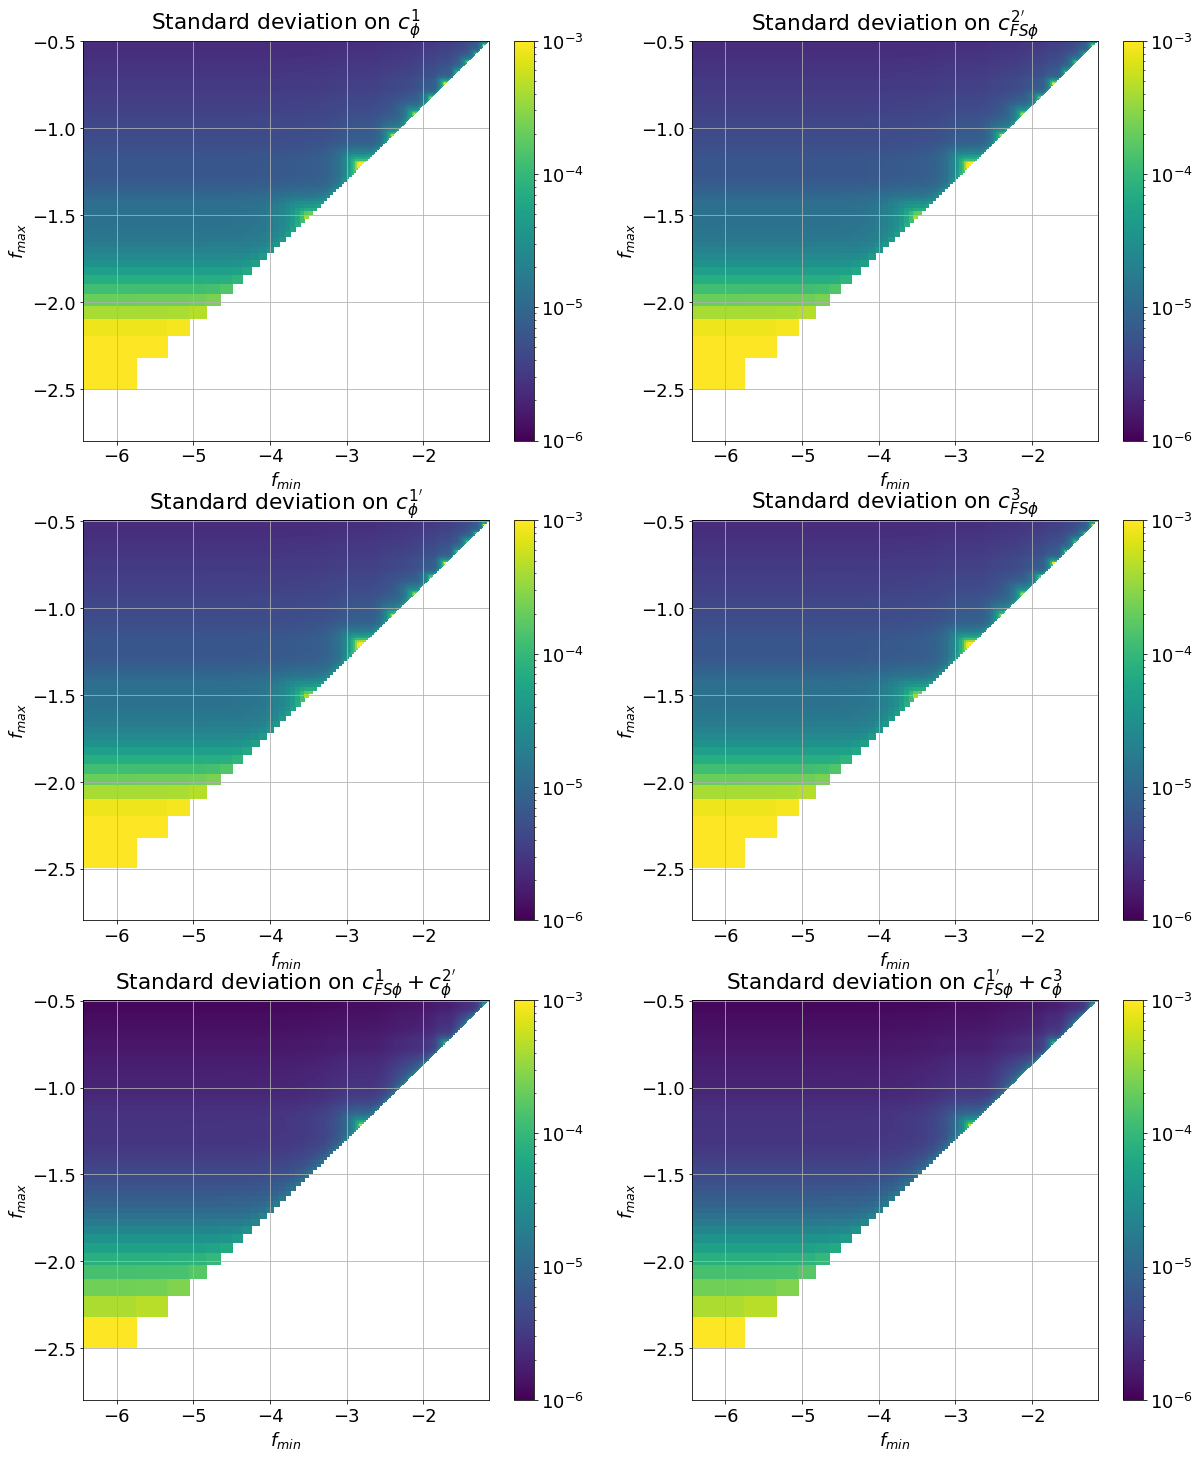

In [17]:
## Plotting contours for sigma

sigmas  = [sigma11, sigma22, sigma33, sigma44, sigma55, sigma66]
ylabels = ['c_{\\phi}^1','c_{FS\\phi}^{2^{\prime}}', 'c_{\\phi}^{1^{\prime}}', 'c_{FS\\phi}^3', 'c_{FS\\phi}^{1} + c_{\\phi}^{2^{\prime}}', 'c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}']

fig= plt.figure(figsize=(20, 25))
for i in range(6):
    i += 1
    plt.subplot('32%s' %i)
    i -= 1
    plt.title('Standard deviation on $%s$' %ylabels[i])
    #c11 = plt.pcolor(Wmax/(2*np.pi), Wmin/(2*np.pi), sigma11, norm=LogNorm(vmin=1e-6, vmax=5e-6))
    c11 = plt.pcolor(np.log(Wmax/(2*np.pi)), np.log10(Wmin/(2*np.pi)), sigmas[i], norm=LogNorm(vmin=1e-6, vmax=1e-3))
    #plt.xlabel('log($f_{min}$)')
    #plt.ylabel('log($f_{max}$)')
    plt.xlabel('$f_{min}$')
    plt.ylabel('$f_{max}$')
    plt.colorbar(c11)
    plt.grid()
plt.savefig('Figures/contour_X_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

print(max(sigma55[199]))